In [335]:
import os
import time

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp

import tensorflow as tf

In [336]:
# The layers and weights of each layer considered when 
# calculating the content loss during gradient descent.

content_layers  = [
    'block4_conv2'
]

content_weights = [
    1.0
]

# The layers and weights of each layer considered when 
# calculating the texture loss during gradient descent.

texture_layers  = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

texture_weights = [
    1.00,
    0.80,
    0.50,
    0.30,
    0.10
]

In [337]:
# Load the VGG-19 network weights.
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

out = [vgg.get_layer(name).output for name in content_layers + texture_layers]
vgg = tf.keras.Model([vgg.inputs], out)

vgg.trainable = False

In [338]:
def get_flattened_layer(tensor):
  ''' Flatten a layer of feature maps in to a 2D tensor / a matrix.

  This function flattens a layer of feature maps in to a 2D tensor / a 
  matrix. If there are N feature maps and each feature map is of 
  dimensions P by Q then the matrix will be of dimensions N by M
  where M = P * Q.

  Parameters:
    tensor (tf.Tensor) - The tensor of feature maps to be flattened.
  
  Returns:
    The feature maps flattened in to a 2D tensor / a matrix.
  '''
  temp = tf.squeeze(tensor)
  temp = tf.transpose(temp, [2, 0, 1])

  h, w = temp.shape[0], temp.shape[1] * temp.shape[2]
  temp = tf.reshape(temp, [h, w])

  return temp

In [339]:
def get_gram_matrix(tensor):
  ''' Get the gram matrix for a layer of feature maps.

  This function returns the gram matrix for a layer of feature maps. As per the
  paper "Image Style Transfer Using Convolutional Neural Networks" 
  (Gatys et al. 2014) this is the matrix of covariances between
  the feature maps in the layer.

  Parameters:
    tensor (tf.Tensor) - The tensor of feature maps in the layer.
  
  Returns:
    The gram matrix for the layer of feature maps.
  '''

  temp = get_flattened_layer(tensor)
  temp = tf.matmul(temp, temp, transpose_b=True)
  
  gram = tf.expand_dims(temp, axis=0)
  return gram

In [340]:
def get_content_loss(content_targets, content_outputs):
  ''' Return the loss between content targets and content outputs.

  This function returns the loss between the content targets and the content
  outputs. As per the paper "Image Style Transfer Using Convolutional Neural
  Networks" (Gatys et al. 2014) this loss is the total euclidean between
  the feature map representations of the images.

  Parameters:
    content_targets (dict) - The target feature map representations.
    content_outputs (dict) - The output feature map representations

  Returns:
    The sum of the euclidean distances between each layer of feature maps in
    content_targets/content_outputs.
  '''

  loss = 0

  for name, weight in zip(content_layers, content_weights):
    loss += weight * tf.math.reduce_sum(
        tf.math.squared_difference(
          content_targets[name],
          content_outputs[name]
        )
    )

  return loss

In [341]:
def get_texture_loss(texture_targets, texture_outputs):
  ''' Return the loss between content targets and content outputs.

  This function returns the loss between the texture targets and the texture
  outputs. As per the paper "Image Style Transfer Using Convolutional Neural
  Networks" (Gatys et al. 2014) this loss is the total euclidean between
  the gram matrices of the feature map representations of the images.

  Parameters:
    texture_targets (dict) - The target feature map representations.
    texture_outputs (dict) - The output feature map representations

  Returns:
    The sum of the euclidean distances between the gram matrices of 
    each layer of feature maps in texture_targets/texture_outputs.
  '''

  loss = 0

  for name, weight in zip(texture_layers, texture_weights):
    target_gram = get_gram_matrix(texture_targets[name])
    output_gram = get_gram_matrix(texture_outputs[name])

    N_l, M_l = target_gram.shape[1], target_gram.shape[2]

    loss += weight * tf.math.reduce_sum(
        tf.math.squared_difference(
            target_gram,
            output_gram
        )
    ) / (4 * N_l ** 2 + M_l ** 2)

  return loss

In [342]:
content_ratio = 1e+0
texture_ratio = 1e+1

epochs    = 10_000
optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

checkpoint_epochs = [0, 16, 32, 64, 128, 256, 512, 1024]

In [343]:
def style_transfer(content, texture, reconstruction,
                   content_ratio=content_ratio, 
                   texture_ratio=texture_ratio,
                   epochs=epochs, 
                   optimizer=optimizer):
  ''' Perform style transfer for given content and texture (style) images.

  This function performs style transfer for given content and texture images.
  This is done as described in the paper "Image Style Transfer Using 
  Convolutional Neural Networks" (Gatys et al. 2014) by performing a
  gradient descent on the reconstruction image until its' content
  matches the content image and texture matches the texture image.

  Parameters:
    content         (tf.Variable) - The content image.
    texture         (tf.Variable) - The texture image.
    reconstruction  (tf.Variable) - The reconstructed image.

    content_ratio (float) - The content ratio for the gradient descent loss.
    texture_ratio (float) - The texture ratio for the gradient descent loss.

    epochs (int) - The number of epochs used in gradient descent.

    optimizer (tf.keras.optimizers.Optimizer) - The optimizer for gradient descent.  
  '''

  content_targets = dict(zip(content_layers + texture_layers, vgg(content)))
  texture_targets = dict(zip(content_layers + texture_layers, vgg(texture)))

  for epoch in range(epochs + 1):
    with tf.GradientTape() as tape:
      
      outputs = dict(zip(content_layers + texture_layers, vgg(reconstruction)))
      
      content_loss = get_content_loss(content_targets, outputs)
      texture_loss = get_texture_loss(texture_targets, outputs)

      loss = content_loss * content_ratio + texture_loss * texture_ratio
      grad = tape.gradient(loss, reconstruction)

    optimizer.apply_gradients([(grad, reconstruction)])
    reconstruction.assign(tf.clip_by_value(reconstruction, clip_value_min=0.0, clip_value_max=1.0))

    if epoch % 100 == 0:
      print('Epoch [{:4} / {:4}]: Content Loss = {:16.4f},   Texture Loss = {:16.4f},   Loss = {:16.4f}'
        .format(epoch, epochs, content_loss, texture_loss, loss))

In [344]:
root = os.path.join('drive', 'My Drive', 'CITS4404 Project')

content_path, content_file = 'Content', 'Elephant.jpeg'
texture_path, texture_file = 'Texture', 'Composition-VII.jpg'

image_h = 512
image_w = 512

In [345]:
# Read, reshape and scale the content image.
content = plt.imread(os.path.join(root, content_path, content_file))
content = content.reshape([1, image_h, image_w, 3])
content = content / 255.0

# Read, reshape and scale the texture image.
texture = plt.imread(os.path.join(root, texture_path, texture_file))
texture = texture.reshape([1, image_h, image_w, 3])
texture = texture / 255.0

# Initialize the reconstructed image to white-noise.
# initial        = tf.random_uniform_initializer(minval=0.0, maxval=1.0)
# reconstruction = tf.Variable(initial([1, image_h, image_w, 3]), trainable=True, dtype=tf.float32)

# Initialize the reconstructed image to the content image.
reconstruction = tf.Variable(content, dtype=tf.float32)

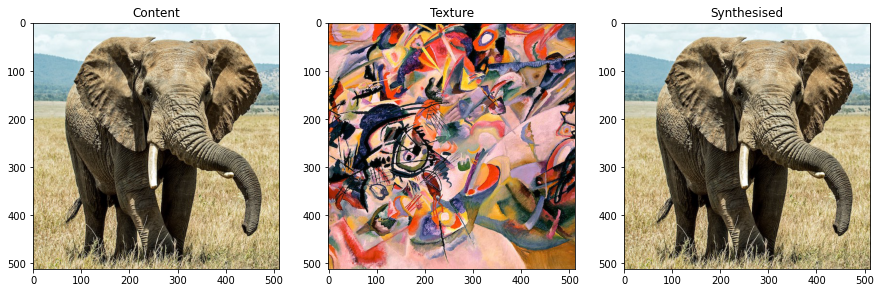

In [346]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax[0].imshow(content[0])
ax[1].imshow(texture[0])
ax[2].imshow(reconstruction[0].numpy())

ax[0].set_title('Content')
ax[1].set_title('Texture')
ax[2].set_title('Synthesised')

plt.show()

In [ ]:
time_1 = time.time()

style_transfer(content, texture, reconstruction,
               content_ratio=1e+0, texture_ratio=5e+1)

time_2 = time.time()
print('Total elapsed time: {} seconds'.format(time_2 - time_1))

Epoch [   0 / 10000]: Content Loss =           0.0000,   Texture Loss = 12712137728.0000,   Loss = 635606859776.0000
Epoch [ 100 / 10000]: Content Loss =   270193536.0000,   Texture Loss =   108535632.0000,   Loss =  5696975360.0000
Epoch [ 200 / 10000]: Content Loss =   292950912.0000,   Texture Loss =    36428476.0000,   Loss =  2114374656.0000
Epoch [ 300 / 10000]: Content Loss =   302271744.0000,   Texture Loss =    16822108.0000,   Loss =  1143377152.0000


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

ax[0].imshow(content[0])
ax[1].imshow(texture[0])
ax[2].imshow(reconstruction[0].numpy())

ax[0].set_title('Content')
ax[1].set_title('Texture')
ax[2].set_title('Synthesised')

for aa in ax:
  aa.axis('off')

plt.savefig(os.path.join(root, 'Results', '{}-and-{}.jpg'.format(content_file, texture_file)), edgecolor='black')
plt.show()